In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.linear_model import ElasticNet, LinearRegression, RidgeCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from fancyimpute import SoftImpute
% matplotlib inline

### Define Helper functions


In [2]:
def remove_missing(datasets):
    # function the ensures all datasets have the rows and that they all have complete data
    datasets = [np.array(i) for i in datasets]
    concat_data = np.hstack(datasets)
    data_rows = np.where(np.all(~np.isnan(concat_data),axis=1))[0]
    cleaned_data = []
    for data in datasets:
        cleaned_data.append(data[data_rows,:])
    return cleaned_data

# using for speed, for the time being
def SoftImpute_df(data):
    # imputes missing data
    if data.isnull().sum().sum()>0:
        imputed_mat = SoftImpute(verbose=False).complete(data)
        return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)
    else:
        print("No missing values, no imputation necessary")
        return data

def split_task(data,task):
    # separates one task's variables from a dataset
    target = data.filter(regex = '^'+task+'\.')
    features = data.drop(target.columns, axis=1)
    return features, target

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,12)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,12)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

In [60]:
def data_transform(data, transforms=[]):
    """
    Takes a list of transforms (sklearn FA o PCA for example) and applies
    them to a dataset. If multiple transforms are provided, the resulting feature
    set will include the data transformed by each of them
    """
    features = None
    # Impute (replace with missForest later)
    imputed_data = SoftImpute_df(data)
    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    for trf in transforms:
        # transform data
        transformed_data = trf.transform(scaled_data)
        if features is None:
            features = transformed_data
        else:
            features = np.hstack((features,transformed_data))
    return features

def data_fit_transform(data, n_components, method=FactorAnalysis):
    """
    Takes a dataset, a data reduction technique (e.g. EFA or PCA) and a 
    list of desire components and fits a model for each # of components. Also
    transforms the data and returns a matrix with each the data transformed by each
    transformation concatenated together
    """
    features = None
    if type(n_components) != list:
        n_components = [n_components]
    # Impute (replace with missForest later)
    imputed_data = SoftImpute_df(data)
    # Scale data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(imputed_data)
    trfs = [] # store fitted transforms
    for c in n_components:
        trf=method(c)
        # fit model on features
        transformed_data = trf.fit_transform(scaled_data)
        trfs.append(trf)
        if features is None:
            features = transformed_data
        else:
            features = np.hstack((features,transformed_data))
    return features, trfs

def train_task_prediction(data, task=None, n_components=None):
    # remove task
    if task is None:
        tasks = np.unique([i.split('.')[0] for i in data.columns])
        task = np.random.choice(tasks)
        print("Using task: %s" % task)
    features,target = split_task(data,task)
    # get reduced feature space
    FA_features, fa_trfs = data_fit_transform(features, n_components)
    PCA_features, pca_trfs = data_fit_transform(features, n_components, method=PCA)
    # remove nans
    target, FA_features, PCA_features = remove_missing([target,
                                                        FA_features,
                                                        PCA_features])
    # predict target
    fa_lr = LinearRegression()
    fa_lr.fit(FA_features, target)
    pca_lr = LinearRegression()
    pca_lr.fit(PCA_features, target)
    return (fa_trfs, fa_lr, pca_trfs, pca_lr)

def test_task_prediction(data, task, train_output):
    # extract train_output
    fa_trfs, fa_lr, pca_trfs, pca_lr = train_output
     # remove task from test data
    features,target = split_task(data,task)
    task_variables = target.columns
    # get reduced feature space
    FA_features = data_transform(features, fa_trfs)
    PCA_features = data_transform(features, pca_trfs)
    # remove nans
    target, FA_features, PCA_features = remove_missing([target,
                                                        FA_features,
                                                        PCA_features])

    # score prediction
    FA_score = {}
    PCA_score = {}
    fa_predicted_vars = fa_lr.predict(FA_features)
    pca_predicted_vars = pca_lr.predict(PCA_features)
    grouped = list(zip(task_variables,target.T,fa_predicted_vars.T, pca_predicted_vars.T))
    for name,var,fa_predicted,pca_predicted in grouped: # iterate over columns:
        FA_score[name] = metrics.r2_score(var, fa_predicted)
        PCA_score[name] = metrics.r2_score(var, pca_predicted)
    return FA_score, PCA_score

def out_of_task_predictionCV(data,task,n_components,verbose=True):
    # cross-validated out of task prediction
    kf = KFold(n_splits=4)
    FA_scores = []
    PCA_scores = []
    for train_index, test_index in kf.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        
        train_output = train_task_prediction(data_train, task, n_components)
        FA_fold_scores, PCA_fold_scores = test_task_prediction(data_test, task, train_output)
        FA_scores.append(FA_fold_scores)
        PCA_scores.append(PCA_fold_scores)
    FA_scores = pd.DataFrame(FA_scores)
    PCA_scores = pd.DataFrame(PCA_scores)
    if verbose:
        print('*'*40)
        print('Leaving out task: %s' % task)
        for col in FA_scores:
            print('\nVariable: %s' % col)
            print("FA Accuracy: %0.2f (+/- %0.2f)" % (FA_scores[col].mean(), FA_scores[col].std() * 2))
            print("PCA Accuracy: %0.2f (+/- %0.2f)" % (PCA_scores[col].mean(), PCA_scores[col].std() * 2))

    return FA_scores.mean(), PCA_scores.mean()

In [ ]:
    predicted = cross_val_predict(lr, FA_transformed_features, target, cv=10)
    predicted = pd.DataFrame(predicted,index=target.index,columns=[i+'_pred' for i in target.columns])
    df = pd.concat([target,predicted], axis=1)
sns.heatmap(df.sort_index(axis=1).corr())

### Load Data

In [111]:
datafile = 'Complete_01-16-2017'
data = get_behav_data(dataset=datafile, file = 'taskdata_clean.csv')


Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


### Example of out of sample prediction

We remove all variables from one task from the data matrix. Then we reduce the dimensionality using FA, which we use to predict the left out variables. We then assess the cross-validated predictive accuracy, and then visualize the optimal coefficients to predict each variable

In [112]:
# show one example
task_name = 'shape_matching'
FA_score, PCA_score= out_of_task_predictionCV(data ,n_components=11, task=task_name)


****************************************
Leaving out task: shape_matching

Variable: shape_matching.hddm_drift
FA Accuracy: 0.41 (+/- 0.08)
PCA Accuracy: 0.39 (+/- 0.08)

Variable: shape_matching.hddm_non_decision
FA Accuracy: 0.22 (+/- 0.06)
PCA Accuracy: 0.23 (+/- 0.05)

Variable: shape_matching.hddm_thresh
FA Accuracy: 0.19 (+/- 0.09)
PCA Accuracy: 0.20 (+/- 0.07)

Variable: shape_matching.stimulus_interference_hddm_drift
FA Accuracy: 0.10 (+/- 0.10)
PCA Accuracy: 0.11 (+/- 0.08)


### Now predict every variable for each task

In [67]:
# run it on every task
tasks = np.unique([i.split('.')[0] for i in data.columns])
scores = pd.DataFrame()
for task in tasks:
    print('Task: %s' % task)
    FA_scores, PCA_scores = out_of_task_predictionCV(data ,n_components=11, 
                                                     task=task,verbose=False)
    scores = pd.concat([scores,pd.DataFrame({'FA':FA_scores,'PCA':PCA_scores})])

Task: adaptive_n_back
Task: angling_risk_task_always_sunny
Task: attention_network_task
Task: bickel_titrator
Task: choice_reaction_time
Task: cognitive_reflection_survey
Task: columbia_card_task_cold
Task: columbia_card_task_hot
Task: dietary_decision
Task: digit_span
Task: directed_forgetting
Task: discount_titrate
Task: dot_pattern_expectancy
Task: go_nogo
Task: hierarchical_rule
Task: holt_laury_survey
Task: information_sampling_task
Task: keep_track
Task: kirby
Task: local_global_letter
Task: motor_selective_stop_signal
Task: probabilistic_selection
Task: psychological_refractory_period_two_choices
Task: ravens
Task: recent_probes
Task: shape_matching
Task: shift_task
Task: simon
Task: simple_reaction_time
Task: spatial_span
Task: stim_selective_stop_signal
Task: stop_signal
Task: stroop
Task: threebytwo
Task: tower_of_london
Task: two_stage_decision
Task: writing_task


### Visualization

First violin plots of the overall distribution of R2 values. Doesn't look so good. But if we sort the variables according to prediction accuracy we can see that there are certain kinds of variables that we can capture, and others that we can't. For instance, drift rates do well, as seen in the last plot

Average Reconstruction Score
FA     0.055853
PCA    0.062657
dtype: float64


/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


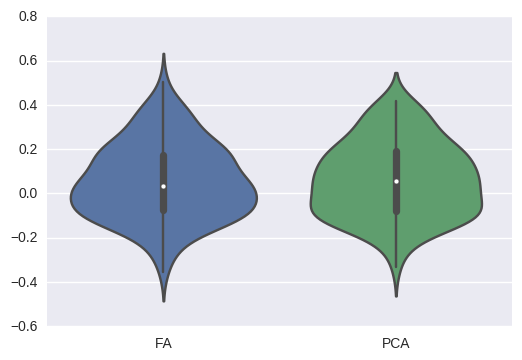

In [79]:
# plot score for FA and PCA reconstruction
print('Average Reconstruction Score')
print(scores.mean())
sns.violinplot(scores)

In [80]:
# tasks in order of FA reconstruction success
scores.sort_values(by='FA', ascending=False)

,FA,PCA
discount_titrate.percent_patient,0.501692,0.385308
shape_matching.hddm_drift,0.411514,0.398471
choice_reaction_time.hddm_drift,0.411087,0.416869
local_global_letter.hddm_drift,0.389843,0.370750
threebytwo.hddm_drift,0.387026,0.391801
adaptive_n_back.hddm_drift,0.366149,0.398174
recent_probes.hddm_drift,0.362360,0.364995
dot_pattern_expectancy.dprime,0.348032,0.310345
dot_pattern_expectancy.hddm_drift,0.335112,0.345311
ravens.score,0.325459,0.349464


DDM Parameter recovery

Average Reconstruction Score for drift rate
FA     0.314241
PCA    0.318768
dtype: float64
Average Reconstruction Score for non_decision rate
FA     0.049846
PCA    0.069493
dtype: float64
Average Reconstruction Score for thresh rate
FA     0.098602
PCA    0.109896
dtype: float64


/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


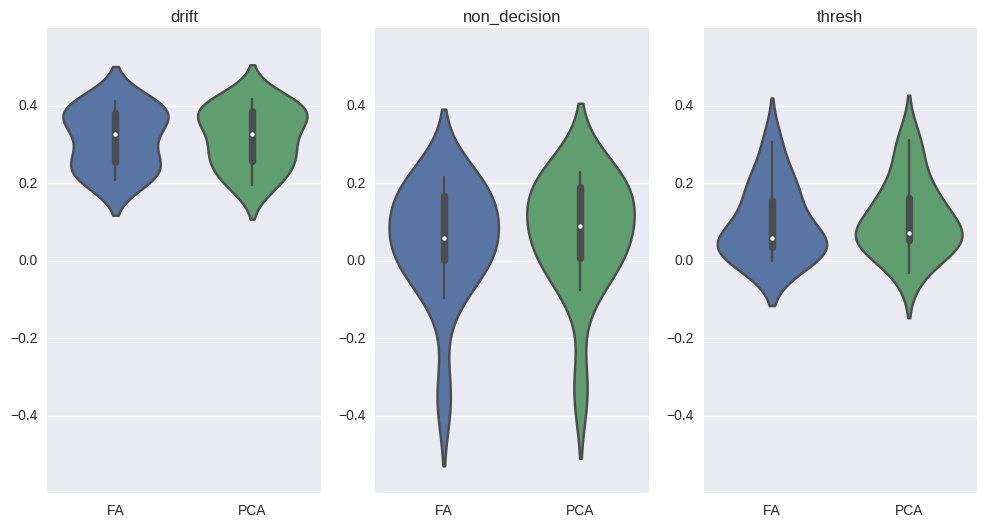

In [141]:
plt.figure(figsize = (12,6))
for i,param in enumerate(['drift','non_decision','thresh']):
    plt.subplot(1,3,i+1)
    param_scores = scores.filter(regex='\.hddm_%s$' % param,axis=0)
    # plot score for FA and PCA reconstruction
    print('Average Reconstruction Score for %s rate' % param)
    print(param_scores.mean())
    sns.violinplot(param_scores)
    plt.title(param)
    plt.ylim([-.6,.6])

### Visualize the local in dimensional space for each variable
Given a particular dimensionality reduction, how are similar variables represented in that space? Currently problematic as I am using imputed data, which allows information to bleed from one variable to another

In [173]:
imputed_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')

# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(imputed_data)
# fit EFA
fa=FactorAnalysis(11)
features = fa.fit_transform(scaled_data)

fit_coefs = {}
targets = pd.DataFrame(scaled_data, columns = imputed_data.columns)
for name,var in targets.T.iterrows():
    lr = LinearRegression()
    lr.fit(features,var)
    fit_coefs[name] = lr.coef_
    
coef_df = pd.DataFrame(fit_coefs)


Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


In [180]:
qtconsole

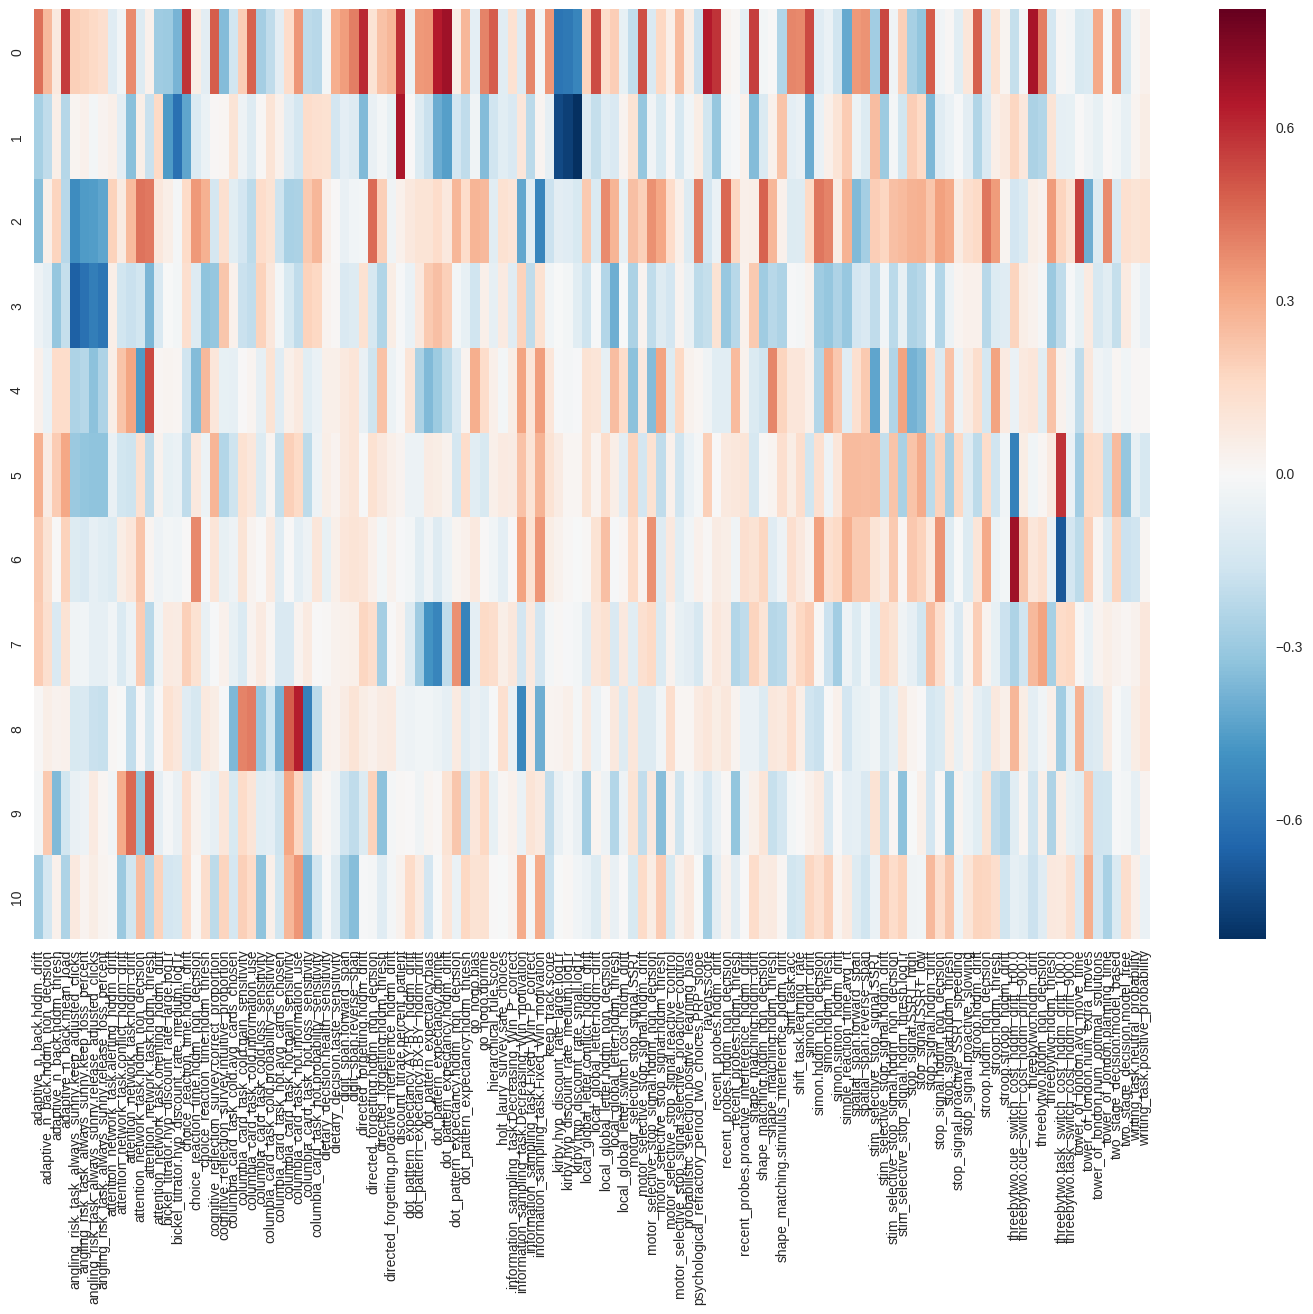

In [177]:
plt.figure(figsize=(18,12))
sns.heatmap(coef_df)

Multidimensional scaling to better visualize the relationship of variables. Below DDM parameters are in purple, andt the size indicates how well the above prediction analysis worked. Hover over the points to see the name of the variable

In [492]:
from sklearn.manifold import MDS
mds = MDS(random_state=7131) # 2 components
visualization_df = pd.DataFrame(mds.fit_transform(coef_df.T),index = coef_df.columns)
visualization_df.loc[:,'FA_score'] = scores.FA-scores.FA.min()

In [685]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

# set up list of variables we want to select in the legend
legend_variables = ['drift','thresh','non_decision','discount']
dropped_vars = visualization_df.filter(regex='|'.join(legend_variables),axis=0).index
static_df = visualization_df.drop(labels=dropped_vars)

fig = plt.figure(figsize=[16,12])
ax = fig.add_axes([0,.1,.7,.8])


# plot variables we don't want to be able to select   
ax.scatter(static_df.iloc[:,0], static_df.iloc[:,1],s=static_df.loc[:,'FA_score']*400,alpha=.5,c='c')

labels = ['everything else']
for subset in legend_variables:
    labels.append(subset)
    subset_df = visualization_df.filter(regex=subset, axis=0)
    ax.scatter(subset_df.iloc[:,0], subset_df.iloc[:,1],
                            s=subset_df.loc[:,'FA_score']*400, alpha = .5, c='m')
    
    
# plot all variables behind the scenes for tooltip
ax.scatter(visualization_df.iloc[:,0], visualization_df.iloc[:,1],s=visualization_df.loc[:,'FA_score']*400,
                              alpha=0)


# interactive tooltip
var_labels = list(visualization_df.index)
tooltip = mpld3.plugins.PointLabelTooltip(ax.collections[-1], labels=var_labels)
# interactive legend
interactive_legend = plugins.InteractiveLegendPlugin(ax.collections[0:-1],
                                                     labels,
                                                     alpha_unsel=0.2,
                                                     alpha_over=4, 
                                                     start_visible=True)

mpld3.plugins.connect(fig, tooltip, interactive_legend)

mpld3.display()
#mpld3.save_html(fig, "MDS_variables.html")